## Evaluasi Model (Calculation Matriks)

In [ ]:
#Evaluasi Setiap Model

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from prettytable import PrettyTable
import timm
import os
import csv

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path ke dataset
test_dir = r"D:\SKRIPSI\Project\dataset-kopi-warga\testing"

# Path model
model_paths = {
    "ResNet50": "model_resnet50_V-30.pth",
    "DenseNet121": "model_densenet121_V-30.pth",
    "EfficientNetB0": "model_efficientNetB0_V-30.pth",
    "MobileNetV2": "model_mobileNetV2_V-30.pth",
    "Xception": "model_xception_V-30.pth"
}

# Transformasi gambar
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset testing
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
num_classes = len(test_dataset.classes)

# Loss function
criterion = nn.CrossEntropyLoss()

# Fungsi untuk load model
def load_model(name, path, num_classes):
    if name == "ResNet50":
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "DenseNet121":
        model = models.densenet121(pretrained=False)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "EfficientNetB0":
        model = models.efficientnet_b0(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "MobileNetV2":
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "Xception":
        model = timm.create_model('xception', pretrained=False, num_classes=num_classes)
    else:
        raise ValueError(f"Model {name} tidak dikenali.")

    model.load_state_dict(torch.load(path, map_location=device))
    return model.to(device)

# Fungsi evaluasi model
def evaluate_model(model, model_name):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    avg_loss = total_loss / len(test_loader)

    return [model_name,
            f"{accuracy * 100:.2f}%",
            f"{avg_loss:.4f}",
            f"{precision:.4f}",
            f"{recall:.4f}",
            f"{f1:.4f}"]

# Evaluasi semua model
results = []
for model_name, model_path in model_paths.items():
    try:
        model = load_model(model_name, model_path, num_classes)
        result = evaluate_model(model, model_name)
        results.append(result)
    except Exception as e:
        print(f"❌ Gagal evaluasi model {model_name}: {e}")
        results.append([model_name, 'Error', 'Error', 'Error', 'Error', 'Error'])

# Tampilkan hasil
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Loss", "Precision", "Recall", "F1 Score"]
for res in results:
    table.add_row(res)

print("\n📊 Evaluasi Semua Model:")
print(table)

# Simpan ke csv
csv_path = "testing_result_V-30.csv"
with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Model", "Accuracy", "Loss", "Precision", "Recall", "F1 Score"])  # Header
    writer.writerows(results)

print(f"\n✅ Hasil evaluasi disimpan ke: {csv_path}")


c:\Users\Ghassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ghassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Ghassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ghassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None`


📊 Evaluasi Semua Model:
+----------------+----------+--------+-----------+--------+----------+
|     Model      | Accuracy |  Loss  | Precision | Recall | F1 Score |
+----------------+----------+--------+-----------+--------+----------+
|    ResNet50    |  90.77%  | 0.2296 |   0.9052  | 0.9191 |  0.9066  |
|  DenseNet121   |  92.31%  | 0.2383 |   0.9181  | 0.9292 |  0.9216  |
| EfficientNetB0 |  96.92%  | 0.1464 |   0.9681  | 0.9681 |  0.9681  |
|  MobileNetV2   |  94.62%  | 0.0815 |   0.9418  | 0.9487 |  0.9447  |
|    Xception    |  96.92%  | 0.1272 |   0.9649  | 0.9740 |  0.9685  |
+----------------+----------+--------+-----------+--------+----------+

✅ Hasil evaluasi disimpan ke: testing_result_V-30.csv


In [2]:
from prettytable import PrettyTable
import torch
import torchvision.models as models
import timm
import os

def get_model_info(model_name, source='torchvision'):
    if source == 'torchvision':
        model = models.__dict__[model_name](pretrained=False)
    elif source == 'timm':
        model = timm.create_model(model_name, pretrained=False)
    else:
        return None

    total_params = sum(p.numel() for p in model.parameters())
    total_layers = len(list(model.named_modules()))
    temp_path = f"{model_name}_temp.pth"
    torch.save(model.state_dict(), temp_path)
    size_mb = os.path.getsize(temp_path) / (1024*1024)
    os.remove(temp_path)

    return {
        "Model": model_name.replace('_', ' ').capitalize(),
        "Jumlah Parameter": f"{total_params:,}",
        "Jumlah Layer": total_layers,
        "Ukuran (MB)": f"{size_mb:.2f}"
    }

models_to_analyze = [
    ('efficientnet_b0', 'torchvision'),
    ('mobilenet_v2', 'torchvision'),
    ('densenet121', 'torchvision'),
    ('resnet50', 'torchvision'),
    ('xception', 'timm')
]

model_data = []
for model_name, source in models_to_analyze:
    info = get_model_info(model_name, source)
    if info:
        model_data.append(info)

table = PrettyTable()
table.field_names = ["Model", "Jumlah Parameter", "Jumlah Layer", "Ukuran (MB)"]

for data in model_data:
    table.add_row([data["Model"], data["Jumlah Parameter"], data["Jumlah Layer"], data["Ukuran (MB)"]])

table.sortby = "Ukuran (MB)"
print(table)


c:\Users\Ghassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ghassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Ghassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


+-----------------+------------------+--------------+-------------+
|      Model      | Jumlah Parameter | Jumlah Layer | Ukuran (MB) |
+-----------------+------------------+--------------+-------------+
|   Mobilenet v2  |    3,504,872     |     213      |    13.60    |
| Efficientnet b0 |    5,288,548     |     337      |    20.46    |
|   Densenet121   |    7,978,856     |     433      |    31.01    |
|     Xception    |    22,855,952    |     216      |    87.48    |
|     Resnet50    |    25,557,032    |     151      |    97.79    |
+-----------------+------------------+--------------+-------------+


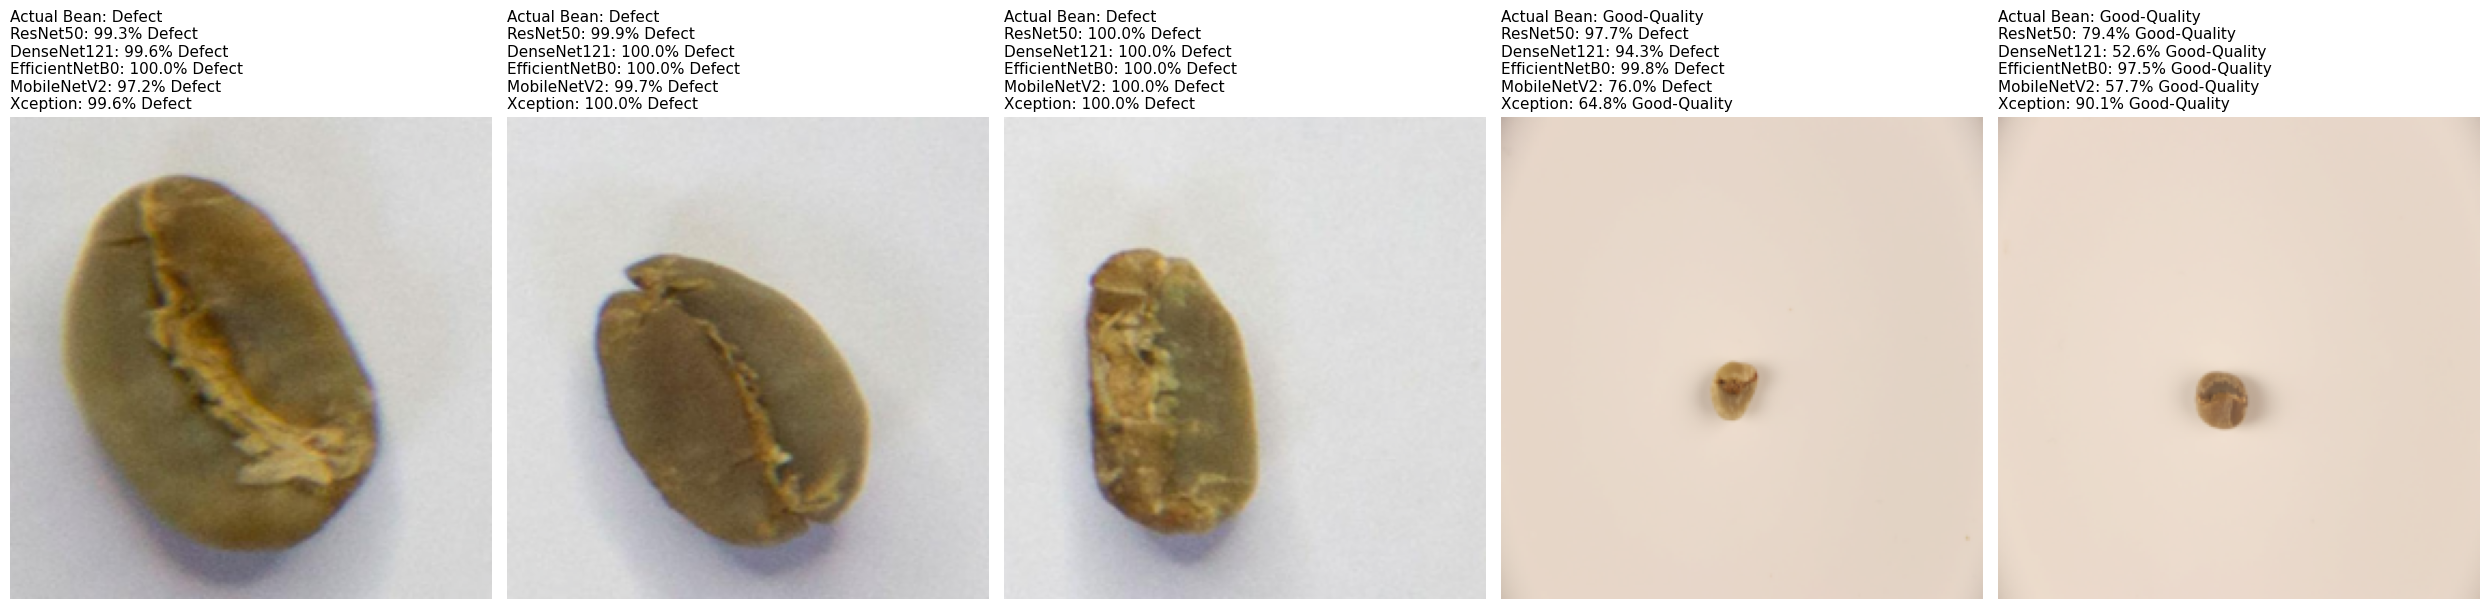

In [6]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import random

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path ke dataset
test_dir = r"D:\SKRIPSI\Project\dataset-kopi-warga\testing"

# Path model
model_paths = {
    "ResNet50": "model_resnet50_V-30.pth",
    "DenseNet121": "model_densenet121_V-30.pth",
    "EfficientNetB0": "model_efficientNetB0_V-30.pth",
    "MobileNetV2": "model_mobileNetV2_V-30.pth",
    "Xception": "model_xception_V-30.pth"
}

# Transformasi gambar
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset testing
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
class_names = test_dataset.classes
num_classes = len(class_names)

# Buat mapping gambar per class
class_to_idx = test_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
samples_by_class = {class_name: [] for class_name in class_names}

for path, label in test_dataset.samples:
    samples_by_class[idx_to_class[label]].append((path, label))

# Ambil 3 Defect dan 2 Good Quality
selected_samples = random.sample(samples_by_class["Defect"], 3) + random.sample(samples_by_class["Good-Quality"], 2)

# Buat custom subset dataset
from PIL import Image
custom_images = []
custom_labels = []

for path, label in selected_samples:
    image = Image.open(path).convert("RGB")
    image = test_transform(image)
    custom_images.append(image)
    custom_labels.append(label)

# Fungsi load model
def load_model(name, path, num_classes):
    if name == "ResNet50":
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "DenseNet121":
        model = models.densenet121(pretrained=False)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "EfficientNetB0":
        model = models.efficientnet_b0(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "MobileNetV2":
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "Xception":
        model = timm.create_model('xception', pretrained=False, num_classes=num_classes)
    else:
        raise ValueError(f"Model {name} tidak dikenali.")
    
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Load semua model
loaded_models = {}
for model_name, model_path in model_paths.items():
    try:
        loaded_models[model_name] = load_model(model_name, model_path, num_classes)
    except Exception as e:
        print(f"❌ Gagal load model {model_name}: {e}")

# Visualisasi
def visualize_selected_images(models_dict, images, labels, class_names):
    fig, axs = plt.subplots(1, len(images), figsize=(5 * len(images), 7))

    if len(images) == 1:
        axs = [axs]

    for idx in range(len(images)):
        img_tensor = images[idx]
        img = img_tensor.numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
        img = np.clip(img, 0, 1)

        axs[idx].imshow(img)
        axs[idx].axis('off')

        actual_class = class_names[labels[idx]]
        texts = [f"Actual Bean: {actual_class}"]

        img_input = img_tensor.unsqueeze(0).to(device)

        for model_name, model in models_dict.items():
            outputs = model(img_input)
            probs = F.softmax(outputs, dim=1)
            conf, pred = torch.max(probs, 1)
            pred_label = class_names[pred.item()]
            texts.append(f"{model_name}: {conf.item() * 100:.1f}% {pred_label}")

        axs[idx].set_title("\n".join(texts), fontsize=11, loc='left')

    plt.tight_layout()
    plt.show()

# Tampilkan hasil
visualize_selected_images(loaded_models, custom_images, custom_labels, class_names)
